# Introduction

This analysis will look at frequency spectra of time series of the 10 outputs by the IMU sensors.  Each time series (128 units of time) will be converted into frequency domain using numpy fft functions.  These frequency spectra will be used as features (instead of the time series).

Random Rain Forest is the only model used to predict. 

In [1]:
# Importing the libraries
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Importing the dataset
X = pd.read_csv('../input/X_train.csv')
X_test=pd.read_csv('../input/X_test.csv')
target=pd.read_csv('../input/y_train.csv')
y=pd.read_csv('../input/sample_submission.csv')
target['surface'].head()

0    fine_concrete
1         concrete
2         concrete
3         concrete
4       soft_tiles
Name: surface, dtype: object

In [3]:
# Get a list of unique surface types
surfaces_list=target['surface'].unique()

In [4]:
seriesID_list=X['series_id'].unique()

In [5]:
# Define a list of column names to store fft data
fft_names_list=['offt_X','offt_Y','offt_Z','offt_W','afft_X','afft_Y','afft_Z','lfft_X','lfft_Y','lfft_Z']
# Prefix offt, afft, and lfft are assgined as the names for fft data of orientation, angular_velocity, and linear_acceleration, respectively

In [6]:
# Scaling train and test sets
pre_scaler = StandardScaler()
X_prescaled     = pd.DataFrame(pre_scaler.fit_transform(X.loc[:,X.columns[3:]]),columns=X.columns[3:])
X_test_prescaled= pd.DataFrame(pre_scaler.transform(X_test.loc[:,X_test.columns[3:]]),columns=X_test.columns[3:])

In [7]:
X_prescaled     =X[X.columns[0:3]].merge(X_prescaled,left_index=True,right_index=True)
X_test_prescaled=X_test[X_test.columns[0:3]].merge(X_test_prescaled,left_index=True,right_index=True)
X_test_prescaled.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.011263,-1.501925,-1.514244,0.068589,-0.056904,-0.106105,-0.035812,-0.015423,0.616632,1.342893
1,0_1,0,1,-0.011132,-1.501897,-1.515660,0.069442,-0.969210,0.853094,-0.180693,-0.448076,0.515887,0.470097
2,0_2,0,2,-0.011036,-1.501883,-1.516603,0.070711,-0.685234,1.201247,-0.078521,0.709837,-0.282079,-0.679748
3,0_3,0,3,-0.010962,-1.501897,-1.515754,0.071070,0.593473,0.287364,-0.072966,0.310959,-0.480484,-1.005896
4,0_4,0,4,-0.010935,-1.501953,-1.513395,0.069808,1.289640,-0.421234,0.016887,1.748275,-0.045965,-0.367308


In [8]:
def fft_calculate(X):
# Calculate FFT data for each series (Each series consists of 128 units of time)
# Each series has 10 parameters (orientation_X,...,angular_velocity_X,....,linear_acceleration_X,...)
# Each of the parameters will be fourier transformed using numpy fft function
    fft_data={}
    fft_names_list=['offt_X','offt_Y','offt_Z','offt_W','afft_X','afft_Y','afft_Z','lfft_X','lfft_Y','lfft_Z']
    for seriesID in range(round(len(X)/128)):
        fft_data[seriesID]={}
        i=-1
        for col in X.columns[3:]:   #stepping through each parameter columns
            c=np.fft.rfft(X[X['series_id']==seriesID][col])  # Calculate real fft
            x=np.real(np.abs(c))  # Calculate the amplitude of fft
            i+=1
            fft_name=fft_names_list[i]  # Assign names for fft data (orientation_X-->offt_X, etc.)
            fft_data[seriesID][fft_name]=x
    return fft_data

In [9]:
# Calculate FFT data for train and test sets

fft_data=fft_calculate(X_prescaled)
fft_test_data=fft_calculate(X_test_prescaled)

In [10]:
# Group series_id's into their respective surface types
seriesID_group={}
for floor_type in surfaces_list:
    seriesID_group[floor_type]=target[target['surface']==floor_type].series_id

# Plotting for data exploration

In [11]:
#Calculate fft average for each parameter_X,Y,Z for each surface.  
#These average values are for viewing only, not used for training.
fft_average={}
for floor_type in surfaces_list:
    count=len(seriesID_group[floor_type])
    fft_average[floor_type]={}
    cumsum={}
    for fft in fft_names_list:
        cumsum[fft]=np.zeros(65)
        for seriesID in seriesID_group[floor_type]:
            cumsum[fft]+=fft_data[seriesID][fft]
        fft_average[floor_type][fft]=np.zeros(65)
        fft_average[floor_type][fft]=cumsum[fft]/count                

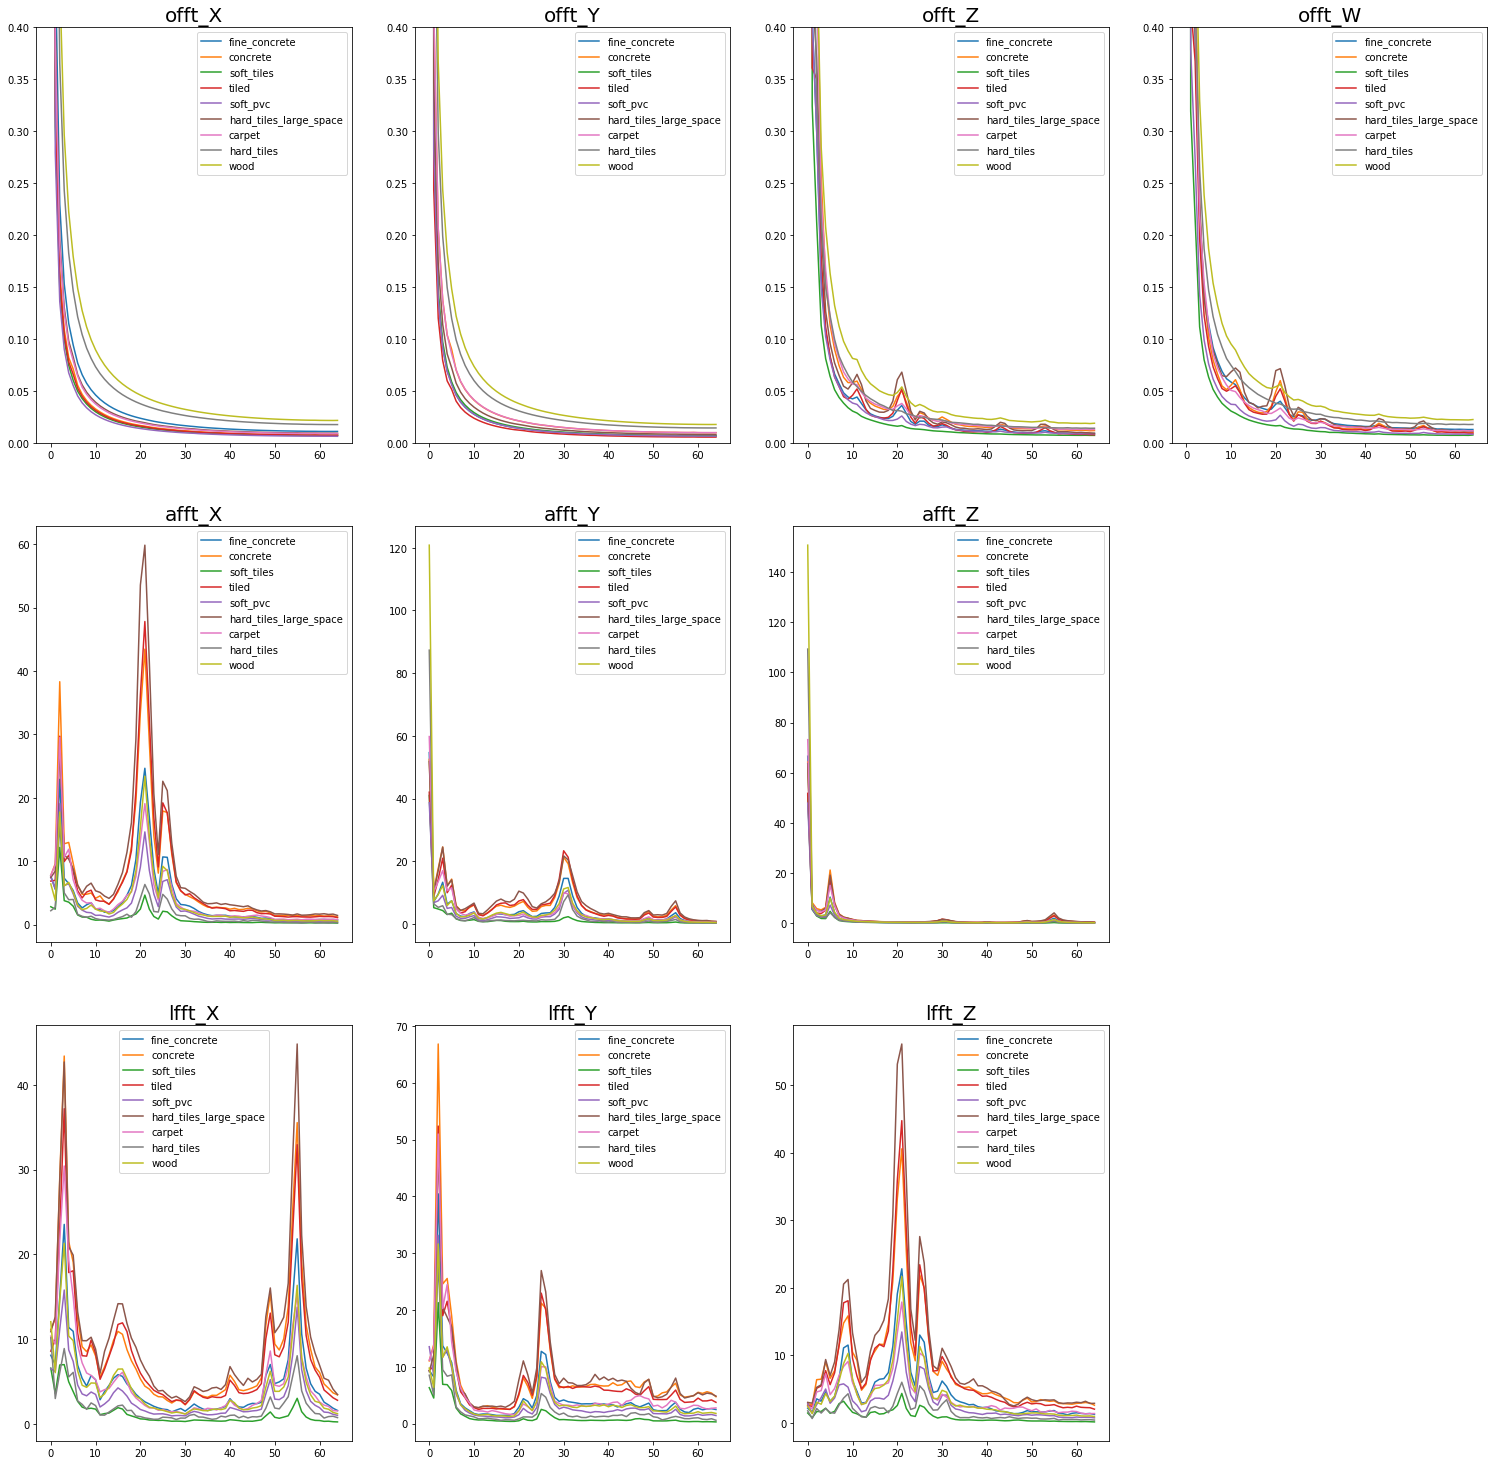

In [12]:
# Preview of fft spectra
plt.figure(figsize=(26, 26))
i=0
for fft in fft_names_list:
    i+=1
    if i==8:
        i+=1
    plt.subplot(3,4,i)
    if fft in ['offt_X','offt_Y','offt_Z','offt_W']:
        plt.ylim(0,0.4)
    plt.title(fft, fontsize=20)
#    plt.yscale('log')
    for floor_type in surfaces_list:
        plt.plot(fft_average[floor_type][fft][:])
    plt.legend(surfaces_list)

# Feature engineering

In [13]:
len(fft_data)

3810

In [14]:
def fft_stats(fft_data):
# Calculate the mean, sum, and standard deviation of spectra 
    df_fft=pd.DataFrame()
    for fft in fft_names_list:
            sum_=fft+'_sum'
            mean=fft+'_mean'
            std=fft+'_std'
            for seriesID in range(len(fft_data)):
                    df_fft.loc[seriesID,sum_]=np.sum(fft_data[seriesID][fft])
                    df_fft.loc[seriesID,mean]=np.mean(fft_data[seriesID][fft])
                    df_fft.loc[seriesID,std]=np.std(fft_data[seriesID][fft])
    return df_fft

In [15]:
df_fft=fft_stats(fft_data)
df_fft_test=fft_stats(fft_test_data)

# Construct Dataframe for training

In [16]:
# Make a copy of fft dataframe
df=df_fft.copy()
df=df.reset_index(drop=True)
df_test=df_fft_test.copy()
df_test=df_test.reset_index(drop=True)

In [17]:
df=target.merge(df,left_index=True,right_index=True)
df.head()

,series_id,group_id,surface,offt_X_sum,offt_X_mean,offt_X_std,offt_Y_sum,offt_Y_mean,offt_Y_std,offt_Z_sum,offt_Z_mean,offt_Z_std,offt_W_sum,offt_W_mean,offt_W_std,afft_X_sum,afft_X_mean,afft_X_std,afft_Y_sum,afft_Y_mean,afft_Y_std,afft_Z_sum,afft_Z_mean,afft_Z_std,lfft_X_sum,lfft_X_mean,lfft_X_std,lfft_Y_sum,lfft_Y_mean,lfft_Y_std,lfft_Z_sum,lfft_Z_mean,lfft_Z_std
0,0,13,fine_concrete,138.411875,2.129413,17.015342,128.354633,1.974687,15.772233,143.353244,2.205435,17.530087,127.102902,1.955429,15.505045,172.280571,2.650470,4.271116,165.590206,2.547542,3.698569,44.710438,0.687853,1.911020,208.101388,3.201560,4.551770,210.553031,3.239277,6.528539,193.882079,2.982801,3.112246
1,1,31,concrete,175.641478,2.702177,21.609155,30.394924,0.467614,3.709957,24.666889,0.379491,2.850741,177.118303,2.724897,21.607334,317.619767,4.886458,7.301513,270.333011,4.158969,5.042641,95.081298,1.462789,3.438063,339.173735,5.218057,4.077873,352.890366,5.429083,8.141335,358.530355,5.515852,6.262698
2,2,20,concrete,92.939858,1.429844,11.348448,166.902564,2.567732,20.491226,172.668360,2.656436,21.081691,83.549457,1.285376,10.160140,211.861670,3.259410,4.704156,194.681304,2.995097,4.582715,65.149856,1.002305,3.288737,210.733768,3.242058,3.156317,296.042565,4.554501,8.048390,213.244111,3.280679,3.057722
3,3,31,concrete,172.041805,2.646797,21.162528,42.713170,0.657126,5.228671,33.006995,0.507800,3.937432,172.752054,2.657724,20.917123,589.405046,9.067770,14.437674,301.621561,4.640332,4.138554,72.090505,1.109085,2.183239,436.493436,6.715284,5.720067,652.301794,10.035412,19.599177,558.336689,8.589795,10.646387
4,4,22,soft_tiles,164.526126,2.531171,20.060062,66.854904,1.028537,7.848612,60.748163,0.934587,7.070375,163.909967,2.521692,20.035019,127.618460,1.963361,3.880550,141.200538,2.172316,6.718746,110.678692,1.702749,8.572508,110.328803,1.697366,2.703601,149.786263,2.304404,5.525958,126.019010,1.938754,2.539218


In [18]:
le = LabelEncoder()
df['surface'] = le.fit_transform(df['surface'])

In [19]:
#Split train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.drop(['surface','group_id','series_id'],axis=1), df['surface'], test_size = 0.2, random_state = 10)

# Training and predict

In [20]:
# List of features
X_train.columns

Index(['offt_X_sum', 'offt_X_mean', 'offt_X_std', 'offt_Y_sum', 'offt_Y_mean',
       'offt_Y_std', 'offt_Z_sum', 'offt_Z_mean', 'offt_Z_std', 'offt_W_sum',
       'offt_W_mean', 'offt_W_std', 'afft_X_sum', 'afft_X_mean', 'afft_X_std',
       'afft_Y_sum', 'afft_Y_mean', 'afft_Y_std', 'afft_Z_sum', 'afft_Z_mean',
       'afft_Z_std', 'lfft_X_sum', 'lfft_X_mean', 'lfft_X_std', 'lfft_Y_sum',
       'lfft_Y_mean', 'lfft_Y_std', 'lfft_Z_sum', 'lfft_Z_mean', 'lfft_Z_std'],
      dtype='object')

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
clf=RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=0)

In [22]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val),columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

In [23]:
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
y_val_predict = clf.predict(X_val_scaled)
y_test_pred = clf.predict(X_test_scaled)

In [25]:
#Result from including full set
from sklearn.metrics import confusion_matrix, accuracy_score
print(round(accuracy_score(y_val, y_val_predict),3))

0.841


In [26]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_scaled.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

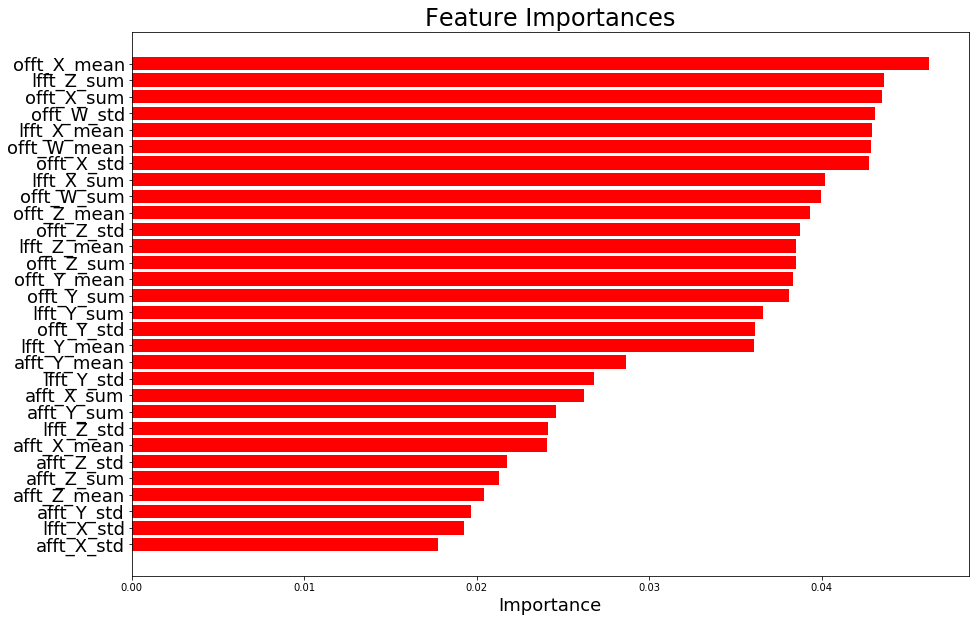

In [27]:
features = X_train_scaled.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15, 10))
plt.title('Feature Importances', fontsize=24)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), features[indices], fontsize=18)
plt.xlabel('Importance', fontsize=18)
plt.show()

In [28]:
confusion_matrix(y_val,y_val_predict)

array([[ 24,   5,   1,   0,   1,   1,   1,   2,   3],
       [  0, 129,   0,   0,   0,   8,   2,   2,   6],
       [  1,   2,  62,   0,   0,   3,   1,   1,   7],
       [  0,   0,   0,   1,   0,   1,   0,   0,   5],
       [  2,   6,   0,   0,  44,   0,   0,   0,   1],
       [  0,   7,   0,   0,   0, 144,   6,   1,  12],
       [  4,   2,   0,   0,   0,   1,  54,   0,   2],
       [  0,   3,   1,   0,   2,   1,   0,  92,   3],
       [  0,   6,   3,   0,   0,   2,   0,   3,  91]])

# Run cross validation for 10 folds

In [29]:
X_train=df.drop(['surface','group_id','series_id'],axis=1)
y_train=df['surface']

In [30]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))

In [31]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(clf, X_train_scaled, y_train, cv=10, scoring="accuracy")
print(np.around(score,3))
print('The average score is: ',round(score.mean(),3))

[0.748 0.836 0.755 0.885 0.871 0.869 0.858 0.863 0.86  0.864]
The average score is:  0.841


# Create Submission data 

In [32]:
y_test_pred=le.inverse_transform(y_test_pred)
y_test_pred[0:10]

array(['hard_tiles_large_space', 'carpet', 'tiled', 'soft_tiles',
       'soft_tiles', 'concrete', 'soft_pvc', 'hard_tiles_large_space',
       'wood', 'soft_pvc'], dtype=object)

In [33]:
y.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [34]:
y['surface']=y_test_pred

In [35]:
y.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,hard_tiles_large_space
8,8,wood
9,9,soft_pvc


In [36]:
y.to_csv('/sample_submission.csv',index=False)